In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interest rate

In [2]:
stir = pd.read_csv('var_ru/ru_stir.csv')
stir = stir[['TIME', 'Value']].copy()
stir['TIME'] = pd.to_datetime(stir['TIME'])
stir.index = stir['TIME']
stir = stir[['Value']].copy()
stir['date'] = stir.index.tolist()

#### inflation rate

In [3]:
infr = pd.read_csv('var_ru/ru_inf.csv')
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()
inf_l = inf_l[:-8]
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%M') + relativedelta(months=i))
infr = pd.DataFrame(inf_l, date_list, ['Value']).iloc[:-4, :]
q_list = []
for y in range(1991, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)
infr['q'] = q_list
g = infr.groupby('q')['Value']
quarters = pd.unique(infr['q']).tolist()
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)
infr = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [4]:
gdp = pd.read_csv('var_ru/ru_gdp_real.csv')
gdp_l = gdp.T.iloc[1:, 1].tolist()
for i in range(len(gdp_l)):
    gdp_l[i] = str(gdp_l[i])
for i in range(len(gdp_l)):
    gdp_l[i] = gdp_l[i].replace(',', '.')
for i in range(len(gdp_l)):
    gdp_l[i] = float(gdp_l[i])
date_list = []
for i in range(0, len(gdp_l)*3, 3):
    date_list.append(datetime.strptime('1995-01', '%Y-%m') + relativedelta(months=i))
gdp = pd.DataFrame(gdp_l, date_list, ['Value'])
gdp['date'] = gdp.index.tolist()

#### Unemployment

In [5]:
umpr = pd.read_csv('var_ru/ru_unemployment.csv')
umpr = umpr[['date', 'fact']].sort_index(axis=0, ascending=False).reset_index(drop=True).copy()
ump_l = umpr['fact'].tolist()[:-1]
for i in range(len(ump_l)):
    ump_l[i] = ump_l[i].replace(',', '.').replace('%', '')
    ump_l[i] = float(ump_l[i])
date_list = []
for i in range(len(ump_l)):
    date_list.append(datetime.strptime('1992-11', '%Y-%m') + relativedelta(months=i))
umpr = pd.DataFrame([ump_l[:-1], date_list], index=['Value', 'date']).T
umpr = umpr.iloc[2:290, :].copy()
q_list = []
for y in range(1993, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)
umpr['q'] = q_list
g = umpr.groupby('q')['Value']
quarters = pd.unique(umpr['q']).tolist()
ur_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    ur_q.append(np.mean(l_g))
umpr = pd.DataFrame([ur_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### Make full DF

In [6]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()
umpr.index = umpr['date']
umpr = umpr[['Value']].copy()

df_var_t = pd.concat([gdp, stir, infr, umpr], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr', 'umpr']

## Stationarity part

Results of Dickey-Fuller Test:
Test Statistic                 -1.359580
p-value                         0.601493
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (10%)           -2.587498
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.669773
p-value                   0.016293
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


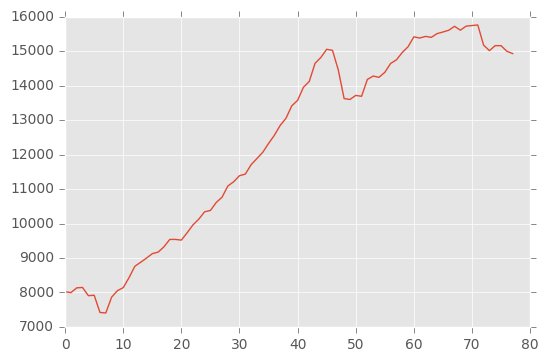

In [8]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.878809
p-value                         0.342095
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (10%)           -2.588072
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
dtype: float64


Results of KPSS Test:
Test Statistic            0.375694
p-value                   0.087632
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


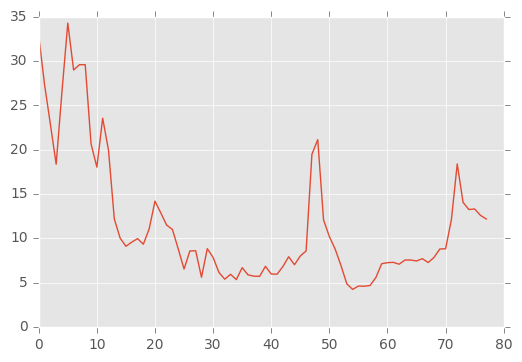

In [9]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.573402
p-value                         0.006290
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (10%)           -2.591103
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
dtype: float64


Results of KPSS Test:
Test Statistic            0.412117
p-value                   0.071932
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


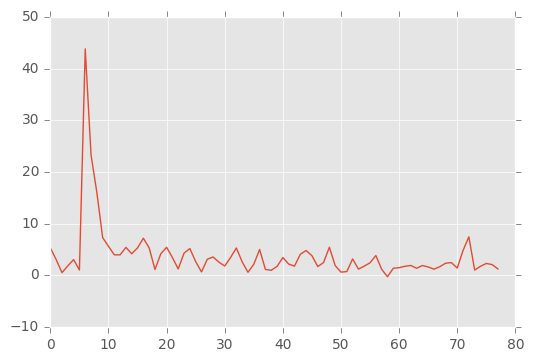

In [10]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.428426
p-value                         0.568575
#Lags Used                      6.000000
Number of Observations Used    71.000000
Critical Value (10%)           -2.588995
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
dtype: float64


Results of KPSS Test:
Test Statistic            0.615949
p-value                   0.021186
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


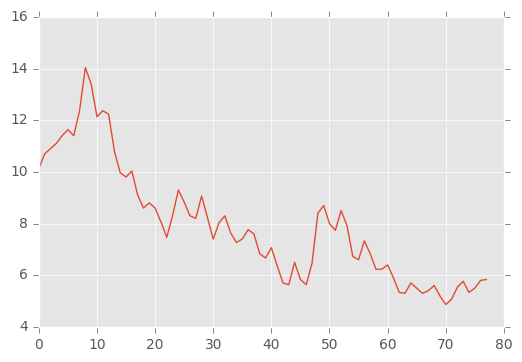

In [11]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                 -5.575741
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    76.000000
Critical Value (10%)           -2.587498
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
dtype: float64


Results of KPSS Test:
Test Statistic            0.235576
p-value                   0.100000
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


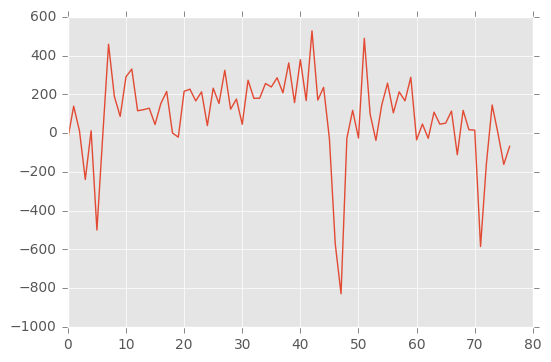

In [12]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -8.596966e+00
p-value                        7.034930e-14
#Lags Used                     1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (10%)          -2.587781e+00
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.398520
p-value                   0.077793
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


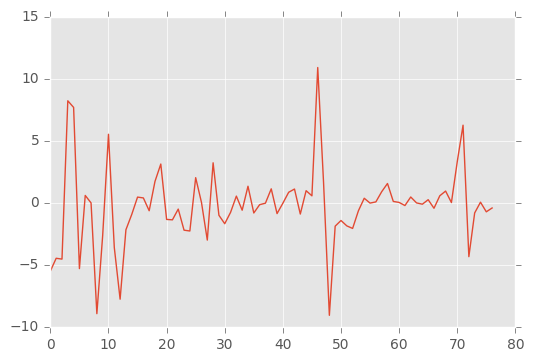

In [13]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -7.011675e+00
p-value                        6.896144e-10
#Lags Used                     2.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (10%)          -2.588072e+00
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.08435
p-value                   0.10000
#Lags Used               12.00000
Critical Value (2.5%)     0.57400
Critical Value (10%)      0.34700
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


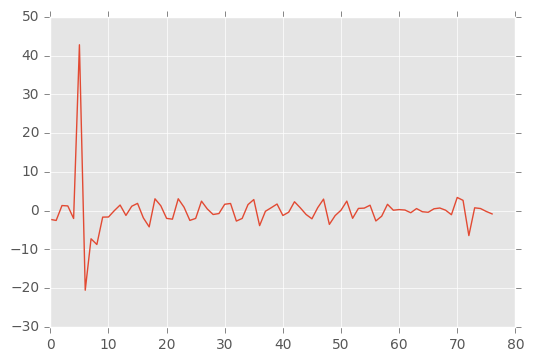

In [14]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                 -3.765608
p-value                         0.003279
#Lags Used                      5.000000
Number of Observations Used    71.000000
Critical Value (10%)           -2.588995
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
dtype: float64


Results of KPSS Test:
Test Statistic            0.080643
p-value                   0.100000
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/Users/Suh/anaconda/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


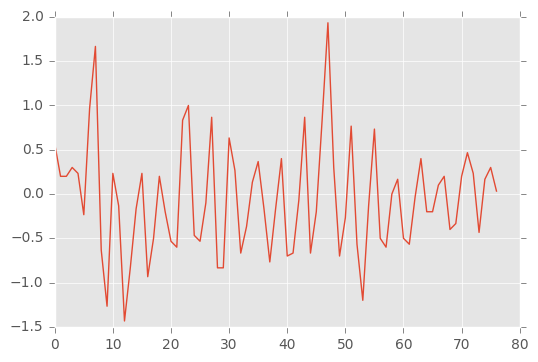

In [15]:
test_stationarity(diff_series(df_var_t['umpr']))

In [16]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [17]:
STEPS = 6
LAG = 2
N_FEAT = 4

In [18]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [19]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [20]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mse': 7.540195658796736, 'mae': 1.6390713374091097, 'rmse': 2.7459416706836173}
{'mse': 9.4441290331672665, 'mae': 2.1200236577737752, 'rmse': 3.0731301686012693}
{'mse': 89359.133441485916, 'mae': 239.83671284724255, 'rmse': 298.9299808341176}
{'mse': 0.050965042071610588, 'mae': 0.21531440620354736, 'rmse': 0.22575438439067044}


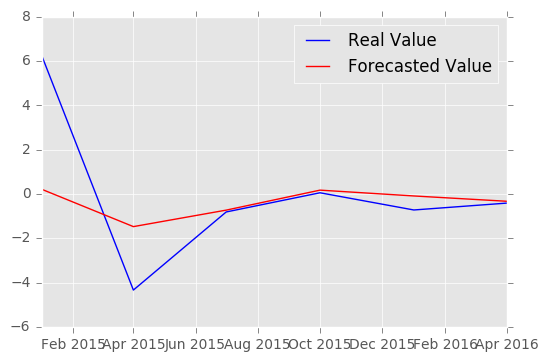

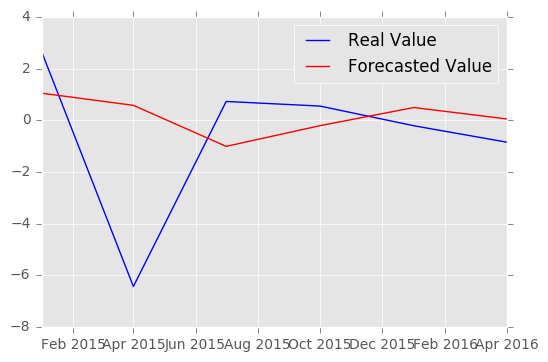

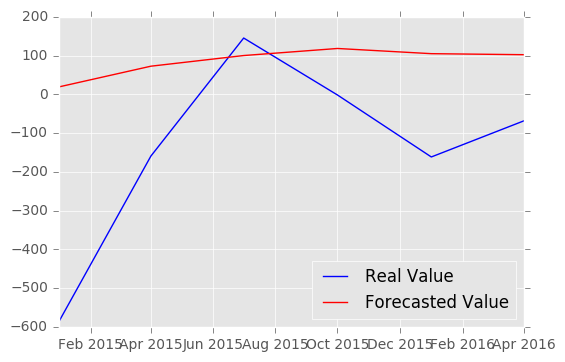

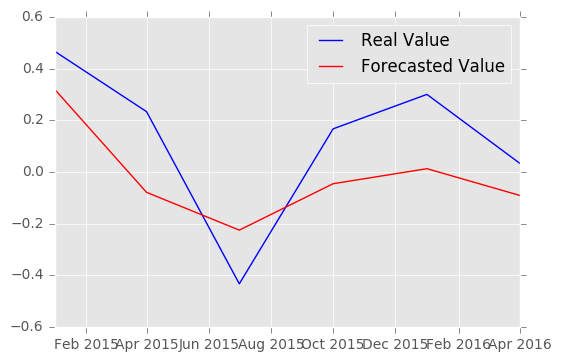

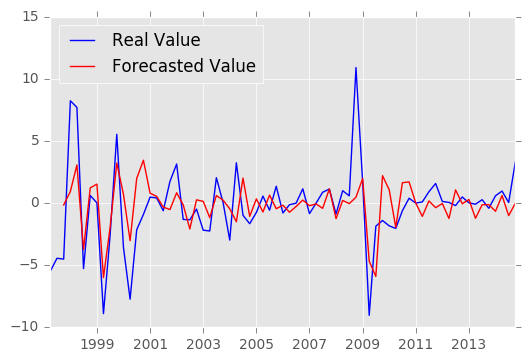

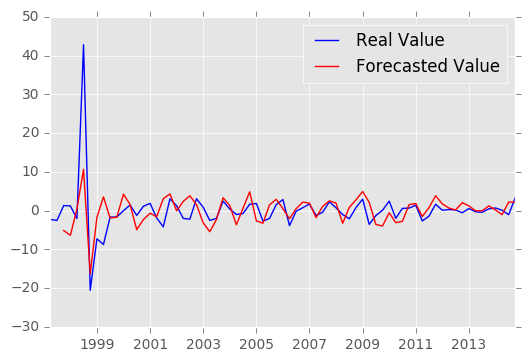

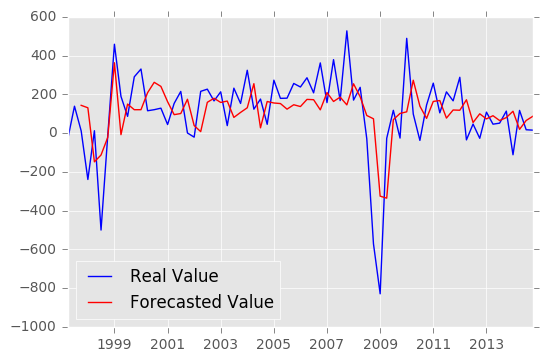

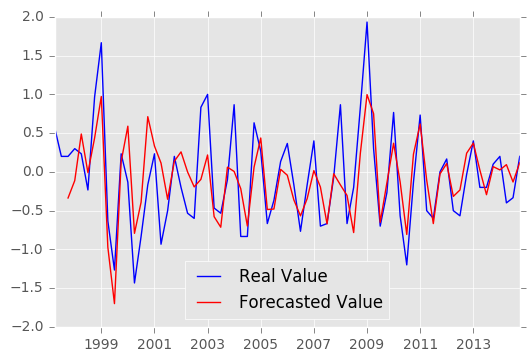

In [21]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['out']['umpr'], test['umpr'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])
plot_compar(var_result['in']['umpr'], train['umpr'])

{'mse': 12.652252845682753, 'mae': 3.3223142699721144, 'rmse': 3.5570005405794856}
{'mse': 14.525740276849675, 'mae': 3.6196114486109203, 'rmse': 3.8112649182193663}
{'mse': 955105.08896089799, 'mae': 945.26870362913996, 'rmse': 977.29478099542621}
{'mse': 0.30737977743981509, 'mae': 0.49173242471894563, 'rmse': 0.55441841369115352}


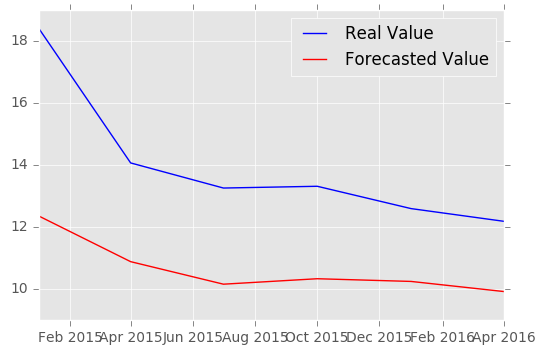

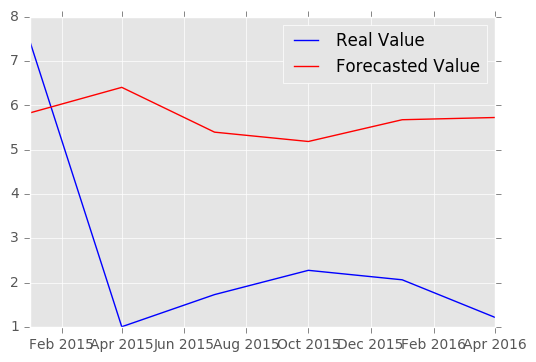

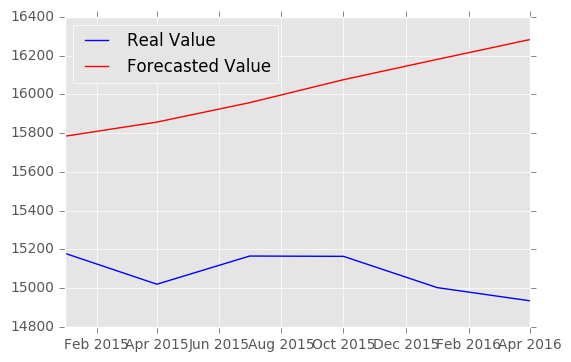

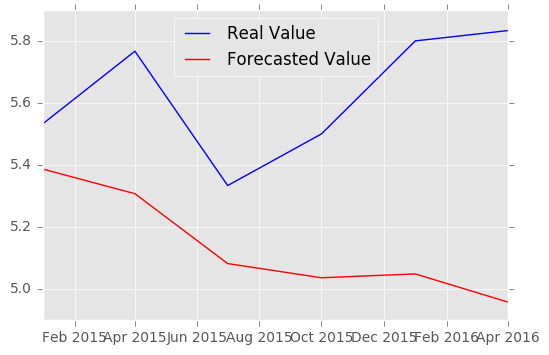

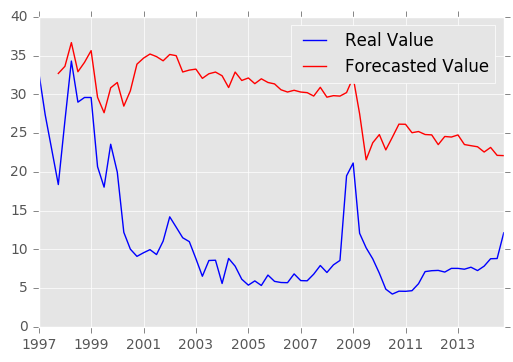

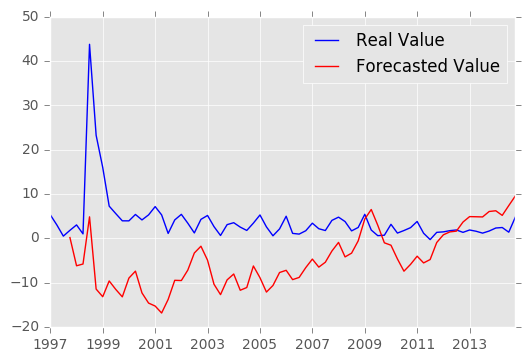

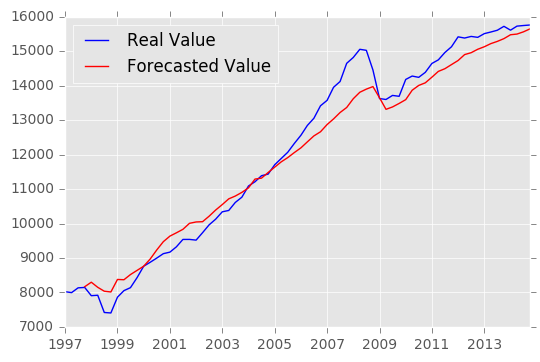

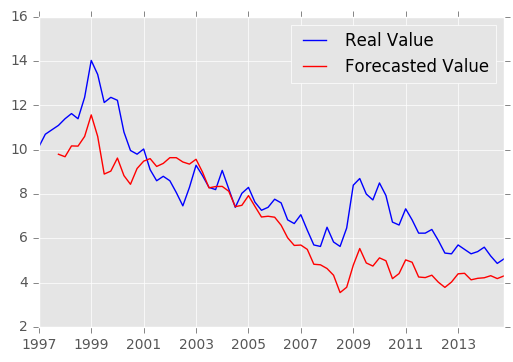

In [22]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

# Hybrid

In [23]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

С DropOut

In [24]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(N_FEAT, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=50, period='q')

Epoch 1/50
0s - loss: 1.2034
Epoch 2/50
0s - loss: 1.1049
Epoch 3/50
0s - loss: 1.0672
Epoch 4/50
0s - loss: 1.0289
Epoch 5/50
0s - loss: 1.0348
Epoch 6/50
0s - loss: 1.0242
Epoch 7/50
0s - loss: 1.0004
Epoch 8/50
0s - loss: 0.9855
Epoch 9/50
0s - loss: 0.9975
Epoch 10/50
0s - loss: 1.0222
Epoch 11/50
0s - loss: 1.0137
Epoch 12/50
0s - loss: 1.0002
Epoch 13/50
0s - loss: 0.9896
Epoch 14/50
0s - loss: 0.9970
Epoch 15/50
0s - loss: 1.0028
Epoch 16/50
0s - loss: 0.9871
Epoch 17/50
0s - loss: 1.0204
Epoch 18/50
0s - loss: 1.0022
Epoch 19/50
0s - loss: 1.0088
Epoch 20/50
0s - loss: 0.9767
Epoch 21/50
0s - loss: 1.0137
Epoch 22/50
0s - loss: 0.9875
Epoch 23/50
0s - loss: 0.9886
Epoch 24/50
0s - loss: 1.0132
Epoch 25/50
0s - loss: 0.9913
Epoch 26/50
0s - loss: 1.0177
Epoch 27/50
0s - loss: 1.0026
Epoch 28/50
0s - loss: 0.9752
Epoch 29/50
0s - loss: 0.9864
Epoch 30/50
0s - loss: 1.0060
Epoch 31/50
0s - loss: 1.0007
Epoch 32/50
0s - loss: 0.9939
Epoch 33/50
0s - loss: 1.0133
Epoch 34/50
0s - lo

{'mse': 11.841405476243345, 'mae': 3.195756746407953, 'rmse': 3.4411343298748664}
{'mse': 11.932019258777027, 'mae': 3.2825457405294913, 'rmse': 3.4542755041798601}
{'mse': 1017405.3897734972, 'mae': 974.65169831948333, 'rmse': 1008.6651524532298}
{'mse': 0.54351899596674003, 'mae': 0.67327818445809873, 'rmse': 0.73723740814390315}


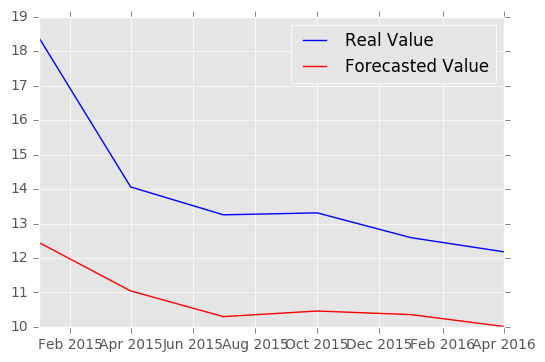

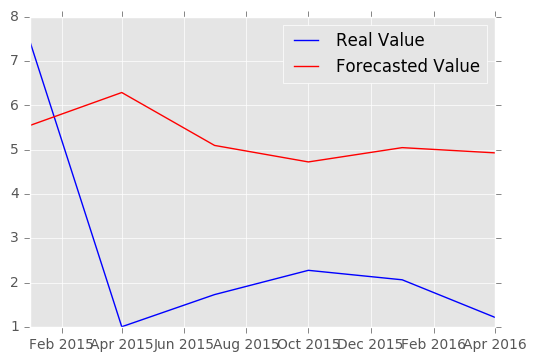

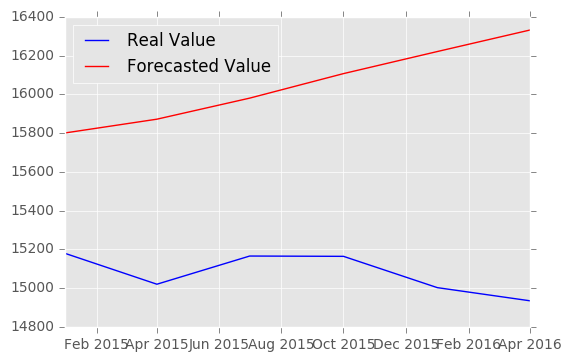

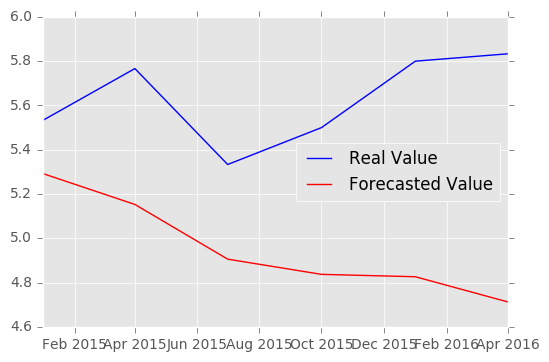

In [25]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))

plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])